# LAB 2.2 - CNS (Hopfield model)

Import of libraries and fix of random seed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

random.seed(0)
np.random.seed(0)

Loading of dataset.

In [2]:
def load_p_data(filename: str) -> np.array:
    """
    Function able to load the dataset of filename variable.

    filename: Name of file where is the dataset.

    returns:
        np.array: data loaded from the file.
    """
    with open(f'lab2_2_data/{filename}.csv') as file:
        return np.array(file.read().split('\n')[:-1]).astype(np.int32)


p0 = load_p_data('p0')
p1 = load_p_data('p1')
p2 = load_p_data('p2')

Function able to show an image from its vector version.

In [3]:
def show_img(p: np.array) -> None:
    """
    Function able to show the image related to the p vector.

    p: Vector related to the image to plot.
    """
    plt.imshow(p.reshape(32, 32).T, cmap='gray', vmin=-1, vmax=1)

Image of 0 digit (p0 vector).

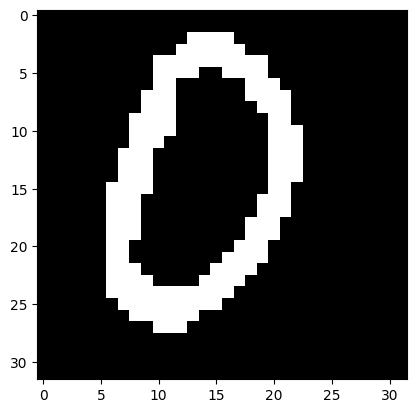

In [4]:
show_img(p0)

Image of 1 digit (p1 vector).

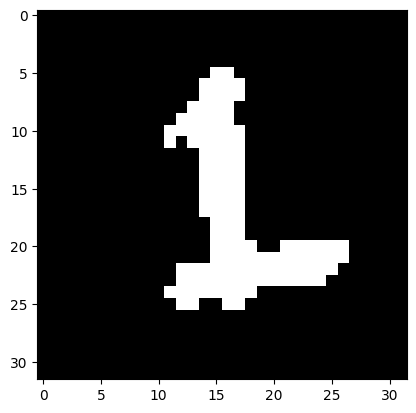

In [5]:
show_img(p1)

Image of 2 digit (p2 vector).

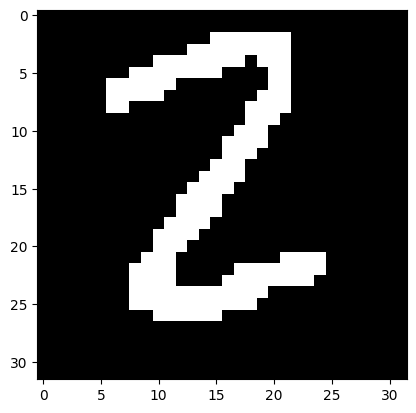

In [6]:
show_img(p2)

Function able to swap the sign of some values inside a vector given the proportion `prop` that lives between 0 and 1.

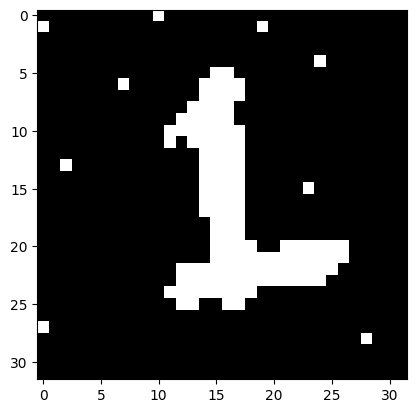

In [7]:
def distort_image(orig_img: np.array, prop: float = 0.05) -> np.array:
    """
    Function able to swap some sign of a vector in proportion to the value of prop.

    orig_img: image to distort.
    prop: Proportion of values to swap.

    returns:
        np.array: Distort version of vector.
    """
    img = orig_img.copy()
    if prop < 0 or prop > 1:
        print('Out-of-bound proportion: going to default 0.05')
        prop = 0.05
    indx = np.random.permutation(len(img))
    todist = indx[1:int(len(indx) * prop)]
    img[todist] = -img[todist]
    return img


show_img(distort_image(p1, prop=0.01))

## Model

In [8]:
class HopfieldNetwork:

    def __init__(self, patterns: np.array, bias: float = 0) -> None:
        self.M, self.N = patterns.shape
        self.patterns = patterns
        self.bias = bias
        self.W = self.store()

    def store(self) -> np.array:
        return (self.patterns.T @ self.patterns - self.M * np.eye(self.N)) / self.N

    def overlap(self, state: np.array) -> list[float]:
        return [(pattern @ state / self.N) for pattern in self.patterns]

    def energy(self, state: np.array) -> float:
        return - state.T @ self.W @ state / 2

    def retrieval(self, state: np.array) -> list[np.array]:
        states = [state.copy()]
        X, X_old = state.copy(), None
        while X_old is None or not np.array_equal(X_old, X):
            X_old = X.copy()
            perms = np.random.permutation(range(self.N))
            for j in perms:
                X[j] = np.sign(self.W[j] @ X + self.bias)
                states.append(X.copy())
        return states

In [9]:
patterns = np.array([p.copy() for p in [p0, p1, p2]])

In [10]:
def discrepancy(X1, X2):
    return ((X1 - X2) > 0).sum()

In [11]:
def perform_retrieval(model: HopfieldNetwork, patterns: np.array, props: list[float] = [0.05, 0.1, 0.25]) -> float:
    tot_discrepancy = 0
    for p in patterns:
        for prop in props:
            X = distort_image(p, prop=prop)
            states = model.retrieval(X)
            Xrec = states[-1]
            tot_discrepancy += discrepancy(X, Xrec)
    return tot_discrepancy / len(patterns) * len(props)

In [12]:
def find_best_bias(patterns: np.array, props: list[float] = [0.05, 0.1, 0.25], configs: int = 5) -> float:
    best_bias, minimum_discrepancy = None, None
    for _ in tqdm(range(configs)):
        bias = np.random.rand() * 2 - 1
        model = HopfieldNetwork(patterns, bias)
        mean_discrepancy = perform_retrieval(model, patterns, props)
        if minimum_discrepancy is None or mean_discrepancy < minimum_discrepancy:
            minimum_discrepancy = mean_discrepancy
            best_bias = bias
    return best_bias

In [13]:
bias = find_best_bias(patterns, configs=100)
perform_retrieval(HopfieldNetwork(patterns, bias), patterns)

  0%|          | 0/100 [00:00<?, ?it/s]

833.0